In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

%matplotlib inline

In [218]:
df_data = pd.read_csv('train.csv')
final_data = pd.read_csv('test.csv')

In [219]:
def does_does_not(cell):
    if cell >= 1:
        return 1
    else:
        return 0

def clean(df):
    # CLEAN COL NAMES
    df.rename(columns= {col: col.lower().replace(' ','_') for col in df.columns}, inplace=True)
    
#     df = df.loc[df['gr_liv_area'] < 4000].copy()

    # CREATION OF DECK/PROCH COLUMN AND SETTING FENCE TO INT
    df['deck_porch'] = df['wood_deck_sf'] + df['open_porch_sf'] + df['enclosed_porch'] + df['3ssn_porch'] + df['screen_porch']
    df['fence'] = df['fence'].notnull().astype('int')
#     df['overall_cond_qual'] = df['overall_cond'] + df['overall_qual']

    # DROPPING COLUMS THAT ARE GOING TO BE BINARY
    df.drop([
    'alley', 'lot_frontage', 'mas_vnr_type', 'fireplace_qu', 'pool_qc', 'misc_feature',
    'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1', 'bsmtfin_type_2',
    'bsmtfin_sf_2', 'bsmt_unf_sf', 'bsmt_full_bath', 'bsmt_half_bath',
    'garage_type', 'garage_yr_blt', 'garage_finish', 'garage_area', 'garage_qual', 'garage_cond',
    'wood_deck_sf', 'open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch',
#     'overall_cond', 'overall_qual'
    ], axis=1, inplace=True)

    # MAKING COLUMNS BINARY
    features_replace = ['pool_area' , 'garage_cars', 'fireplaces', 'mas_vnr_area', 'deck_porch'] # 'total_bsmt_sf', 
    for i in features_replace:
        df[i] = df[i].map(does_does_not)

    # RENAMING BINARY COLUMNS
    df.rename(columns={
    'pool_area': 'has_pool',
    'garage_cars': 'has_garage', 
    'fireplaces': 'has_fireplace',
#     'total_bsmt_sf': 'has_bsmt',
    'mas_vnr_area': 'has_mas_vnr',
    'fence': 'has_fence'}, inplace=True)


    # COMBINING SIMILAR/SAMLL VALES
    df['lot_shape'] =df['lot_shape'].replace({'IR3':'IR2'})
    df['condition_1'] =df['condition_1'].replace({'PosA':'Pos', 'PosN':'Pos', 'RRAe':'RRe', 'RRNe':'RRe', 'RRNn':'RRn', 'RRAn':'RRn'})
    df['condition_2'] =df['condition_2'].replace({'PosA':'Pos', 'PosN':'Pos', 'RRAe':'RRe', 'RRNe':'RRe', 'RRNn':'RRn', 'RRAn':'RRn'})
#     df['year_built'] = pd.to_datetime(df['year_built'], format='%Y')
#     df['year_remod/add'] = pd.to_datetime(df['year_remod/add'], format='%Y')
#     df['mo_sold'] = pd.to_datetime(df['mo_sold'], format='%m')
#     df['yr_sold'] = pd.to_datetime(df['yr_sold'], format='%Y')
    
    # CATEROGRY TO NUMBERICAL
    df['exter_qual'] = df['exter_qual'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})
    df['exter_cond'] = df['exter_cond'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})
    df['heating_qc'] = df['heating_qc'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})
    df['electrical'] = df['electrical'].replace({'SBrkr': 5, 'FuseA': 4, 'FuseF': 3, 'FuseP': 2, 'Mix': 1})
    df['kitchen_qual'] = df['kitchen_qual'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})

    # DROPPING SIMILAR COLUMNS
    df.drop(['1st_flr_sf', '2nd_flr_sf', 'bedroom_abvgr'], axis=1, inplace=True) # , 'gr_liv_area'

    # DUMMIES FOR CAT COLUMNS
    df = pd.get_dummies(df, columns=[
    'neighborhood',
    'lot_shape',
    'ms_subclass',
    'ms_zoning',
    'land_contour',
    'lot_config',
    'utilities',
    'land_slope',
    'condition_1',
    'condition_2',
    'bldg_type',
    'exterior_1st',
    'exterior_2nd',
    'foundation',
    'heating',
    'central_air',
    'full_bath',
    'half_bath',
    'kitchen_abvgr',
    'functional',
    'paved_drive',
    'sale_type',
    'street',
    'house_style',
    'roof_style',
    'roof_matl',
    'electrical'
    ], prefix=[
    'n_',
    'ls_',
    'mssub_',
    'mszon_',
    'landcon_',
    'lotfig_',
    'ut_',
    'landm_',
    'cond1_',
    'cond2_',
    'btype_',
    'ext1_',
    'ext2_',
    'found_',
    'heat_',
    'ac_',
    'fb_',
    'hb_',
    'kita_',
    'funct_',
    'paved_',
    'stype_',
    'st_',
    'hstyle_',
    'rst_',
    'rmat_',
    'ele_'
    ])
    
    return df 

In [220]:
df = clean(df_data)
final = clean(final_data)
df = df.loc[df['gr_liv_area'] < 4000].copy()

In [221]:
def mia_columns(df1, df2):
    mia_df2 = list(set(df1.columns) - set(df2.columns))
    print(mia_df2)
    mia_df1 = list(set(df2.columns) - set(df1.columns))
    print(mia_df1)
    
    for i in mia_df2:
        df2[i] = 0
    
    for i in mia_df1:
        df2.drop([i], axis=1, inplace=True)
    
    df1['total_bsmt_sf'].fillna(0, inplace=True)
    df2['total_bsmt_sf'].fillna(0, inplace=True)

In [222]:
mia_columns(df, final)

['mszon__A (agr)', 'saleprice', 'n__Landmrk', 'ele__5', 'ut__NoSeWa', 'ext1__Stone', 'ele__2', 'cond2__Artery', 'rmat__ClyTile', 'rmat__Membran', 'funct__Sal', 'ext2__Stone', 'sale_condition', 'ext1__ImStucc', 'ele__3', 'heat__OthW', 'ele__4', 'funct__Sev', 'mssub__150', 'ele__1', 'cond2__RRe', 'cond2__RRn', 'heat__Wall', 'n__GrnHill', 'ext1__CBlock']
['ext2__PreCast', 'rmat__Roll', 'ext2__Other', 'rmat__Metal', 'ext1__PreCast', 'ele__2.0', 'ele__3.0', 'ele__5.0', 'stype__VWD', 'heat__Floor', 'ele__4.0']


In [92]:
df_droping = pd.read_csv('train.csv')

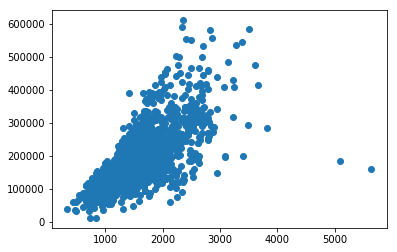

In [94]:
xax = df_droping['Gr Liv Area']
yax = df_droping['SalePrice']
plt.scatter(xax, yax)

In [100]:
df_droping.loc[df_droping['Gr Liv Area'] < 4000]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2010,WD,Abnorml,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,138500
5,138,535126040,20,RL,137.0,16492,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,190000
6,2827,908186070,180,RM,35.0,3675,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2006,New,Partial,140000
7,145,535154050,20,RL,NaN,12160,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,5,2010,COD,Abnorml,142000
8,1942,535353130,20,RL,NaN,15783,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,Shed,400,6,2007,WD,Normal,112500
9,1956,535426130,60,RL,70.0,11606,Pave,NaN,IR1,HLS,...,0,NaN,NaN,NaN,0,9,2007,WD,Family,135000


In [115]:
y = df['saleprice']
X = df.drop(['id', 'pid', 'sale_condition', 'saleprice'], axis=1)
# select all but id, pid, sale_condition, saleprice

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [117]:
lr = LinearRegression()
lr.fit(X_train_sc, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [118]:
print('train', lr.score(X_train_sc, y_train))
print('test', lr.score(X_test_sc, y_test))

train 0.909608735344
test -6.85442443707e+22


In [119]:
X_test.shape

(513, 209)

In [120]:
final.shape

(876, 213)

In [44]:
list(set(final.columns) - set(X_test.columns))

['pid', 'sale_condition', 'id', 'saleprice']

In [ ]:
X_train_sc

In [150]:
enet = ElasticNet()
params = {
    'alpha': np.arange(.1, .4, .005),
    'l1_ratio': np.arange(.001, .01, .05)
}
gs = GridSearchCV(enet, params, n_jobs=-1)
gs.fit(X_train_sc, y_train)
gs.best_params_

{'alpha': 0.24500000000000013, 'l1_ratio': 0.001}

In [124]:
gs.score(X_test_sc, y_test)

0.90009285430478059

In [39]:
pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score').head()

C:\Users\Mark\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Mark\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Mark\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Mark\Anaconda3\lib\site-packages\sklearn\utils\depr

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,param_l1_ratio,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
32,0.050467,0.002005,0.830379,0.886592,0.26,0.001,"{'alpha': 0.26, 'l1_ratio': 0.001}",1,0.856013,0.883818,0.849460,0.882883,0.785576,0.893074,0.002632,0.001638,0.031762,0.004599
31,0.051136,0.001337,0.830377,0.886852,0.255,0.001,"{'alpha': 0.255, 'l1_ratio': 0.001}",2,0.856038,0.884091,0.849520,0.883169,0.785485,0.893296,0.002165,0.000945,0.031824,0.004572
33,0.054478,0.001338,0.830376,0.886332,0.265,0.001,"{'alpha': 0.265, 'l1_ratio': 0.001}",3,0.855982,0.883546,0.849396,0.882598,0.785662,0.892852,0.003692,0.000472,0.031701,0.004626
30,0.051137,0.001337,0.830370,0.887112,0.25,0.001,"{'alpha': 0.25, 'l1_ratio': 0.001}",4,0.856060,0.884363,0.849575,0.883454,0.785387,0.893518,0.005114,0.000473,0.031887,0.004545
34,0.049799,0.001671,0.830368,0.886072,0.27,0.001,"{'alpha': 0.27, 'l1_ratio': 0.001}",5,0.855947,0.883273,0.849328,0.882313,0.785742,0.892629,0.002501,0.000473,0.031640,0.004653


In [40]:
# X_final = final.drop(['id', 'pid', 'sale_condition', 'saleprice'], axis=1)
# X_final_sc = ss.transform(X_final)
# predictions = gs.predict(X_final_sc)

In [41]:
# final['SalePrice'] = predictions
# final[['id','SalePrice']].to_csv('export_clean_attempt2.csv', index=False)

In [50]:
len(X_train.columns)

210

In [51]:
len(gs.best_estimator_.coef_)

210

In [66]:
from sklearn.linear_model import Ridge

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101)
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [149]:
ridge2 = Ridge(alpha=250)
ridge2.fit(X_train_sc, y_train)

ridge2.score(X_test_sc, y_test)
# 0.7895619048565512


0.88886474097524315

In [ ]:
# X_final = final.drop(['id', 'pid', 'sale_condition', 'saleprice'], axis=1) # , 'SalePrice'
# X_final_sc = ss.transform(X_final)
# predictions = ridge.predict(X_final_sc)

# final['SalePrice'] = predictions
# final[['id','SalePrice']].to_csv('export_ridge.csv', index=False)

In [ ]:
living area vs sale price

## fit on everything

In [137]:
ye = df['saleprice']
Xe = df.drop(['id', 'pid', 'sale_condition', 'saleprice'], axis=1)
# select all but id, pid, sale_condition, saleprice

In [138]:
ss = StandardScaler()
Xe_sc = ss.fit_transform(Xe)

In [139]:
ridge = Ridge(alpha=250)
ridge.fit(Xe_sc, ye)

Ridge(alpha=250, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [141]:
X_final = final.drop(['id', 'pid', 'sale_condition', 'saleprice'], axis=1) # , 'SalePrice'
X_final_sc = ss.transform(X_final)
predictions = ridge.predict(X_final_sc)

In [142]:
final['SalePrice'] = predictions
final[['id','SalePrice']].to_csv('export_ridge_fit_everything_a250.csv', index=False)

In [143]:
[a for a in predictions if a < 0]

[-9386.3247156638245,
 -10359.999188234156,
 -3078.3098256469239,
 -967.8090431173041]

In [136]:
coeffs3 = pd.DataFrame(index=X_train.columns,data= ridge2.coef_ )

coeffs3.sort_values(by=0)

,0
n__Gilbert,-3279.576597
mssub__120,-2643.835826
funct__Sev,-2377.791352
n__NAmes,-2267.165489
rst__Gable,-2149.128377
funct__Maj1,-2141.812978
hb__0,-2005.244411
mssub__160,-1914.190043
rst__Mansard,-1871.420297
stype__COD,-1783.599213


In [128]:
coeffs2 = pd.DataFrame(index=X_train.columns,data= ridge.coef_ )

coeffs2.sort_values(by=0)

,0
mssub__160,-8172.090679
mssub__120,-7999.693215
ext2__CmentBd,-4034.746102
mssub__180,-3065.874179
mssub__80,-3048.763227
hstyle__1Story,-2992.850670
funct__Maj1,-2855.674998
btype__1Fam,-2777.047933
ext1__VinylSd,-2470.913733
n__NWAmes,-2445.930966


In [57]:
coeffs = pd.DataFrame(index=X_train.columns,data= gs.best_estimator_.coef_ )

In [59]:
coeffs.sort_values(by=0)

,0
rmat__ClyTile,-7277.732063
misc_val,-5893.919408
n__Edwards,-2855.775864
n__Gilbert,-2760.829232
mssub__160,-2292.495753
n__NAmes,-2154.459318
found__CBlock,-1849.152260
hb__0,-1823.477286
rst__Gable,-1808.058420
stype__COD,-1706.927840


In [20]:
gs.best_estimator_.coef_

array([[  3.53134487e+03,   6.95363910e+03,   1.08579591e+03,
          2.83434388e+03,   2.74890236e+03,   3.21174448e+03,
          4.32538983e+03,  -3.42124555e+01,   5.92126885e+03,
          1.40840646e+03,   6.39103475e+03,  -5.72331206e+02,
          4.57983293e+03,   4.96927161e+03,   4.38363984e+03,
          1.36523086e+03,   5.95566355e+02,  -2.49659684e+02,
         -5.24364137e+02,   3.99674043e+02,   1.47925573e+02,
          1.59466477e+03,  -5.19523719e+02,   3.51342148e+02,
         -2.54359524e+02,  -3.08368551e+01,   9.61996353e+02,
         -5.93691930e+02,   1.73338860e+03,  -2.42442073e+03,
         -1.80724140e+03,   4.53285173e+02,   7.84601976e+02,
         -2.95356019e+02,  -1.42439671e+02,  -1.66405111e+03,
         -1.59240837e+02,  -1.37933592e+03,  -7.79151846e+01,
         -1.13272038e+02,   3.67654742e+03,   4.30277469e+03,
         -1.01326339e+03,  -7.43854982e+02,  -6.06939426e+02,
         -1.46360824e+03,   1.24048068e+03,   2.58461158e+03,
        

## Pipeline

In [152]:
from sklearn.pipeline import Pipeline 

In [154]:
from sklearn.linear_model import Lasso

In [228]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [229]:
X_train.shape

(1536, 209)

In [230]:
final.shape

(879, 214)

In [231]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('pca', PCA()),
    ('lasso', Lasso())
])

In [232]:
params = {
    'lasso__alpha': np.logspace(2,3,20),
    'pca__n_components': np.arange(50, 80, 1)
}

In [233]:
gs = GridSearchCV(pipe, param_grid=params, n_jobs=-1, verbose=1)

In [234]:
gs.fit(X_train,y_train)

Fitting 3 folds for each of 600 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 687 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 1387 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1793 out of 1800 | elapsed:  1.4min remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  1.4min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'lasso__alpha': array([  100.     ,   112.88379,   127.4275 ,   143.84499,   162.37767,
         183.29807,   206.91381,   233.57215,   263.66509,   297.63514,
         335.98183,   379.26902,   428.13324,   483.29302,   545.55948,
         615.84821,   695.1928 ,   784.75997,   885.86679,  1000.     ]), 'pca__n_components': array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 

In [235]:
gs.best_score_
# 0.8672905336425929
# 0.8497604729158833
# 0.85351929303589413

0.84799593135635842

In [236]:
gs.best_params_
# {'lasso__alpha': 885.86679041008233}
# {'lasso__alpha': 233.57214690901213, 'pca__n_components': 77}
# {'lasso__alpha': 143.8449888287663, 'pca__n_components': 78}

{'lasso__alpha': 127.42749857031335, 'pca__n_components': 79}

In [237]:
final.shape

(879, 214)

In [238]:
X.shape

(2049, 209)

In [241]:
X_final = final.drop(['id', 'pid', 'sale_condition', 'saleprice', 'rmat__ClyTile'], axis=1) # , 'SalePrice'

In [242]:
list(set(X_final.columns) - set(X.columns))

[]

In [243]:
pred = gs.predict(X_final)

In [244]:
[pre for pre in pred if pre < 0]

[]

In [246]:
final['SalePrice'] = pred
final[['id','SalePrice']].to_csv('export_lasso2.csv', index=False) 

In [245]:
gs.score(X_test, y_test)

0.85959072959327265

## Testing Decision Tree

In [22]:
from sklearn.tree import DecisionTreeRegressor

In [71]:
dtr = DecisionTreeRegressor(random_state=101)
dtr.fit(X_train_sc, y_train)
params = {
    'max_depth': np.arange(1, 6, 1),
    'max_features': [1, 4, 'sqrt', 'log2']
}
gs = GridSearchCV(dtr, params, n_jobs=-1)
gs.fit(X_train_sc, y_train)
gs.best_params_



# max_depth grid search over
# max_features 

# possibly try ensambling trees

{'max_depth': 4, 'max_features': 'log2'}

In [72]:
gs.score(X_test_sc, y_test)

0.49367651000132406

In [73]:
gs.score(X_train_sc, y_train)

0.51339071915400081

In [80]:
# X_final = final.drop(['id', 'pid', 'sale_condition', 'saleprice', 'SalePrice'], axis=1)
# X_final_sc = ss.transform(X_final)
# predictions = gs.predict(X_final_sc)

In [81]:
# final['SalePrice'] = predictions
# final[['id','SalePrice']].to_csv('export_dtree.csv', index=False)

## Random Forest

In [67]:
from sklearn.ensemble import RandomForestRegressor

In [91]:
rf = RandomForestRegressor(random_state=101)

rf.fit(X_train_sc, y_train)
params = {
#     'criterion': ['mse', 'mae'],
    'max_depth': np.arange(1, 6, 1),
    'max_features': [1, 4, 'sqrt', 'log2']
}
gs = GridSearchCV(rf, params, n_jobs=-1)
gs.fit(X_train_sc, y_train)
gs.best_params_

{'criterion': 'mse', 'max_depth': 5, 'max_features': 'sqrt'}

In [92]:
gs.score(X_test_sc, y_test)
# 0.7113133578831945

0.7113133578831945

In [93]:
gs.score(X_train_sc, y_train)
# 0.73776835169906929

0.73776835169906929

In [88]:
# X_final = final.drop(['id', 'pid', 'sale_condition', 'saleprice', 'SalePrice'], axis=1)
# X_final_sc = ss.transform(X_final)
# predictions = gs.predict(X_final_sc)

In [89]:
# final['SalePrice'] = predictions
# final[['id','SalePrice']].to_csv('export_rf.csv', index=False)

## Gradient Boosting

In [94]:
from sklearn.ensemble import GradientBoostingRegressor

In [113]:
gb = GradientBoostingRegressor(random_state=101)

gb.fit(X_train_sc, y_train)
params = {
    'loss': ['huber'], #['ls', 'lad', 'huber', 'quantile']
    'max_depth': np.arange(4, 6, 1),
    'criterion': ['mae'], #['mse', 'mae', 'friedman_mse']
    'max_features': [1, 4, 'sqrt', 'log2'],
    'n_estimators': [1000, 10000]
}
gs = GridSearchCV(gb, params, n_jobs=-1)
gs.fit(X_train_sc, y_train)
gs.best_params_

{'criterion': 'mae',
 'loss': 'huber',
 'max_depth': 5,
 'max_features': 'log2',
 'n_estimators': 1000}

In [114]:
gs.score(X_test_sc, y_test)
# plain 0.90252878976979123
# huber 0.89292379875671601
# {'loss': 'huber', 'max_depth': 5} 0.90589232431861111
# {'criterion': 'mae', 'loss': 'huber', 'max_depth': 3} 0.90597834698026458
# {'criterion': 'mae', 'loss': 'huber', 'max_depth': 5, 'max_features': 'sqrt'} 0.9045417183283615
# {'criterion': 'mae',
# 'loss': 'huber', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 300} 0.90794842532518771
# {'criterion': 'mae', 'loss': 'huber', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 1000} 0.90790961372937073

0.90790961372937073

In [115]:
gs.score(X_train_sc, y_train)
# 0.93918822856034878
# 0.9309919929623941
# 0.97217982680214243
# 0.92993912736295514
# 0.94199221769889019
# 0.96241756998979489
# 0.98467198273141898

0.98467198273141898

In [116]:
# X_final = final.drop(['id', 'pid', 'sale_condition', 'saleprice', 'SalePrice'], axis=1)
# X_final_sc = ss.transform(X_final)
# predictions = gs.predict(X_final_sc)

In [117]:
# final['SalePrice'] = predictions
# final[['id','SalePrice']].to_csv('export_gb.csv', index=False)

## SVR

In [14]:
from sklearn.svm import SVR

In [15]:
svr = SVR(verbose=True)

svr.fit(X_train_sc, y_train)
params = {
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [3,4],
    'C': [15, 20],
}
gs = GridSearchCV(svr, params, n_jobs=-1)
gs.fit(X_train_sc, y_train)
gs.best_params_

[LibSVM][LibSVM]

{'C': 20, 'degree': 3, 'kernel': 'linear'}

In [19]:
gs.score(X_test_sc, y_test)
# -0.061633291974839681
# linear 0.16649637247328819
# c=3 0.41431378303430599
# {'C': 20, 'degree': 3, 'kernel': 'linear'} 0.76676970456362969

0.78003588419893066

In [20]:
gs.score(X_train_sc, y_train)
# -0.053018817800281282
# 0.17806148048421822
# 0.42678741656518404
# 0.77592513773713501

0.78619676937983274

In [144]:
# X_final = final.drop(['id', 'pid', 'sale_condition', 'saleprice', 'SalePrice'], axis=1)
# X_final_sc = ss.transform(X_final)
# predictions = gs.predict(X_final_sc)

In [145]:
# final['SalePrice'] = predictions
# final[['id','SalePrice']].to_csv('export_svr2.csv', index=False)

## KNN

In [22]:
from sklearn.neighbors import KNeighborsRegressor

In [23]:
knn = KNeighborsRegressor()

knn.fit(X_train_sc, y_train)
params = {
    'n_neighbors': np.arange(7, 10, 1),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
gs = GridSearchCV(knn, params, n_jobs=-1)
gs.fit(X_train_sc, y_train)
gs.best_params_

{'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'distance'}

In [24]:
gs.score(X_test_sc, y_test)
# 0.7484117445075622

0.77933389080430449

In [25]:
gs.score(X_train_sc, y_train)
# 0.81229272409369702

0.99999909579182777

In [152]:
# X_final = final.drop(['id', 'pid', 'sale_condition', 'saleprice', 'SalePrice'], axis=1)
# X_final_sc = ss.transform(X_final)
# predictions = gs.predict(X_final_sc)

In [153]:
# final['SalePrice'] = predictions
# final[['id','SalePrice']].to_csv('export_knn2.csv', index=False)

## PCA
pca is not a model

In [175]:
from sklearn.decomposition import PCA

In [178]:
pca = PCA()

In [179]:
pca.fit(X,y)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [181]:
pca.explained_varianc

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [34]:
pca = PCA(random_state=101)

pca.fit(X_train_sc, y_train)
params = {
    'n_components': np.arange(5, 11, 1)
}
gs = GridSearchCV(pca, params, n_jobs=-1)
gs.fit(X_train_sc, y_train)
gs.best_params_

{'n_components': 7}

In [35]:
gs.score(X_test_sc, y_test)
# -5.7107619729432733e+28

-288.98765330425243

In [36]:
gs.score(X_train_sc, y_train)
# 370.17779211088396

-283.72960133398453

In [ ]:
# X_final = final.drop(['id', 'pid', 'sale_condition', 'saleprice'], axis=1) # , 'SalePrice'
# X_final_sc = ss.transform(X_final)
# predictions = gs.predict(X_final_sc)

In [ ]:
# final['SalePrice'] = predictions
# final[['id','SalePrice']].to_csv('export_pca.csv', index=False)